### Importing the dependencies to work with

In [65]:
import lmfit
import rampy as rp #Charles' libraries and functions

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

###  Reading the data file

In [66]:
# Load Data
filename = 'Data/qg27_thyl_XY08'
data = pd.read_csv(filename, delimiter = "\t", names=["x", "y"])

### Visualize the Data

In [67]:
fig = px.line(data_frame=data, x=data['x'], y=data['y'])
fig.show()

In [68]:
# Convert Dataframe data to numpy arrays for working with smoothening and correction
data_array = data.to_numpy()
x = data_array[:,0]
y = data_array[:,1]


For smoothening

In [69]:
# Incase to smooth
# y_smo = rp.smooth(data_array[:,0],data_array[:,1],method="savgol",window_length=5,polyorder=3)
# y_smo = rp.smooth(x,y,method="whittaker",Lambda=10**0.5)

Check the smoothen and raw data

In [70]:
# Check the plots before and after smooth
# plt.figure(figsize=(8,8))
# plt.subplot(2,1,1)
# plt.plot(x, y)
# plt.title("Raw Data")
# plt.subplot(2,1,2)
# plt.title("Smoothen Data")
# plt.plot(data_array[:,0], y_smo)

#### Select the region of Interest (ROI)

In [71]:
roi = np.array([(1347,1365),(1774,1800)])
roi[1,1]

1800

### Baseline Fitting and trimming the data

In [72]:
# Base line correction
y_corr, y_base = rp.baseline(x,y,roi,'poly',polynomial_order=3)

# Trim the data
x_fit = x[np.where((x > roi[0,0])&(x < roi[1,1]))]
y_fit = y_corr[np.where((x > roi[0,0])&(x < roi[1,1]))]

Plot the trimmed data

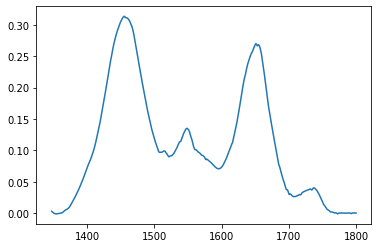

In [73]:
plt.figure()
plt.plot(x_fit,y_fit)
# plt.xlim([1347,1849])
# plt.title("Trimmed Data non-normalized")

Normalized the trimmed data and plot

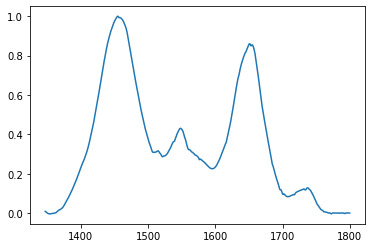

In [74]:
y_fit_norm_intensity = rp.normalise(y_fit,x=x_fit,method="intensity")
plt.plot(x_fit,y_fit_norm_intensity)
# plt.title("Trimmed Data normalized to max intensity")


Text(0.5, 1.0, 'B) signal to fit')

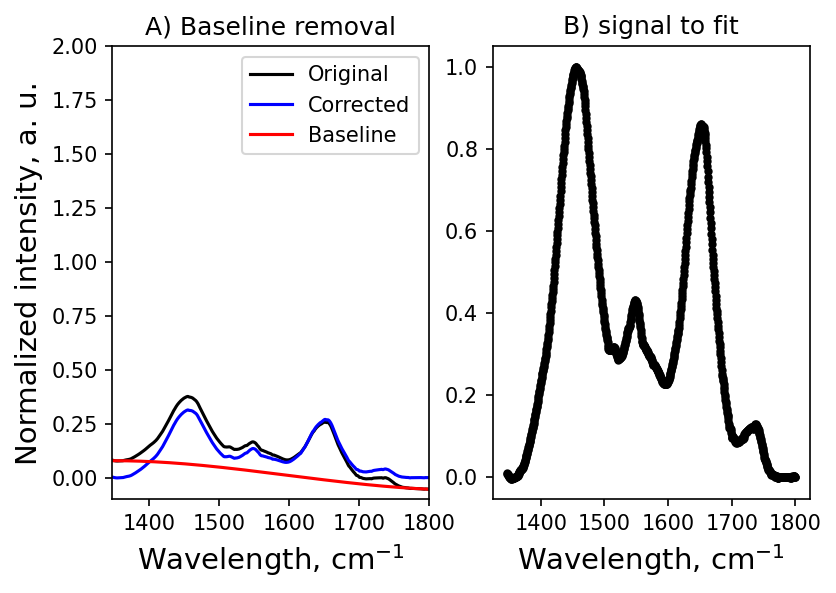

In [76]:
# create a new plot for showing the spectrum
plt.figure(dpi=150)
plt.subplot(1,2,1)
inp = plt.plot(x,y,'k-',label='Original')
corr = plt.plot(x,y_corr,'b-',label='Corrected') #we use the sample variable because it is not already normalized...
bas = plt.plot(x,y_base,'r-',label='Baseline')
plt.xlim(roi[0,0],roi[1,1])
plt.ylim(-0.1,2)
plt.xlabel("Wavelength, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)
plt.legend()
plt.title('A) Baseline removal')

plt.subplot(1,2,2)
plt.plot(x_fit,y_fit_norm_intensity,'k.')
plt.xlabel("Wavelength, cm$^{-1}$", fontsize = 14)
plt.title('B) signal to fit')
#plt.tight_layout()
# plt.suptitle('Figure 2', fontsize = 14,fontweight = 'bold')

### Replot for quick check for the input paramaters 

In [77]:
arr = np.column_stack((x_fit,y_fit_norm_intensity))
my_array = pd.DataFrame(arr, columns = ['x_fit','y_fit'])
fig = px.line(data_frame=my_array, x=my_array['x_fit'], y=my_array['y_fit'])
fig['layout']['xaxis']['autorange'] = "reversed"
fig.show()

It would be good to check the plot and assign initial parameters in the parameters section for good and faster fit.

### Parameters Section

Make sure to add equal number of parameters as you have used in case of the residual local function . 

In [78]:
params = lmfit.Parameters()
algo = 'leastsq'
#               (Name,  Value,   Vary,   Min,     Max,       Expr)
params.add_many(
                # Protein
                ('a1',   0.1,    True,    0,      0.2,     None), #Amplitude
                ('f1',   1740,   True,   1735,    1755,    None), #position
                ('l1',   5,      True,    1,      50,     None), # FWHM

                ('a2',   0.04,    True,     0,      0.2,    None),   #Amplitude
                ('f2',   1725,   True,   1720,     1745,     None),
                ('l2',    5,    True,    1,       50,    None), 
                # Lipid
                ('a3',   0.9,    True,    0,       1,        None),  # Amplitude
                ('f3',   1654,   True,    1640,   1660,     None),
                ('l3',   20,     True,     10,     40,      None),

                ('a4',   0.9,    True,      0,      1,      None), # Amplitude
                ('f4',   1636,   True,   1630,    1650,     None),
                ('l4',   20,     True,     10,     80,      None), 
                
                ####
                ('a5',   0.3,    True,    0.0,     1,       None), # Amplitude
                ('f5',   1547,   True,    1592,    1505,    None),
                ('l5',   40,     True,     0,      100,     None),

                ('a6',   0.7,    True,     0.0,       1,    None), # Amplitude
                ('f6',   1453,   True,    1425,    1470,    None),
                ('l6',   20,     True,     0,      50,      None),   
                
                ('a7',   0.07,    True,     0.0,    1,      None), # Amplitude
                ('f7',   1378,   True,    1350,    1380,    None),
                ('l7',   10,     True,     0,      10,      None),   
                        
               )
params  

name,value,initial value,min,max,vary
a1,0.10000000,0.1,0.00000000,0.20000000,True
f1,1740.00000,1740,1735.00000,1755.00000,True
l1,5.00000000,5,1.00000000,50.0000000,True
a2,0.04000000,0.04,0.00000000,0.20000000,True
f2,1725.00000,1725,1720.00000,1745.00000,True
l2,5.00000000,5,1.00000000,50.0000000,True
a3,0.90000000,0.9,0.00000000,1.00000000,True
f3,1654.00000,1654,1640.00000,1660.00000,True
l3,20.0000000,20,10.0000000,40.0000000,True
a4,0.90000000,0.9,0.00000000,1.00000000,True


### Run Fit

In [79]:
from Modules.custom_funx import residual, create_residuals_df, plot_res , plot_fit


In [80]:
result = lmfit.minimize(residual, params, method = algo, args=(x_fit, y_fit_norm_intensity[:,0]))
print(lmfit.fit_report(result))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 202
    # data points      = 940
    # variables        = 21
    chi-square         = 0.19838941
    reduced chi-square = 2.1588e-04
    Akaike info crit   = -7913.59916
    Bayesian info crit = -7811.83568
[[Variables]]
    a1:  0.07672804 +/- 0.06318764 (82.35%) (init = 0.1)
    f1:  1740.53786 +/- 2.79127268 (0.16%) (init = 1740)
    l1:  10.3258310 +/- 2.24781103 (21.77%) (init = 5)
    a2:  0.07333982 +/- 0.02910402 (39.68%) (init = 0.04)
    f2:  1723.20171 +/- 9.42688448 (0.55%) (init = 1725)
    l2:  15.1245129 +/- 6.80670058 (45.00%) (init = 5)
    a3:  0.65676547 +/- 0.11238129 (17.11%) (init = 0.9)
    f3:  1652.37792 +/- 0.55400780 (0.03%) (init = 1654)
    l3:  23.3418333 +/- 1.32861277 (5.69%) (init = 20)
    a4:  0.24733186 +/- 0.09093700 (36.77%) (init = 0.9)
    f4:  1630.26406 +/- 10.2560191 (0.63%) (init = 1636)
    l4:  37.9923754 +/- 2.04389013 (5.38%) (init = 20)
    a5:  0.34898656 +/- 0

### Get all the residuals

In [81]:
yout, peak1,peak2,peak3,peak4,peak5,peak6, peak7 = residual(result.params,x_fit)
res_stack = np.column_stack((yout,peak1,peak2,peak3,peak4,peak5,peak6,peak7))



['Data']


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

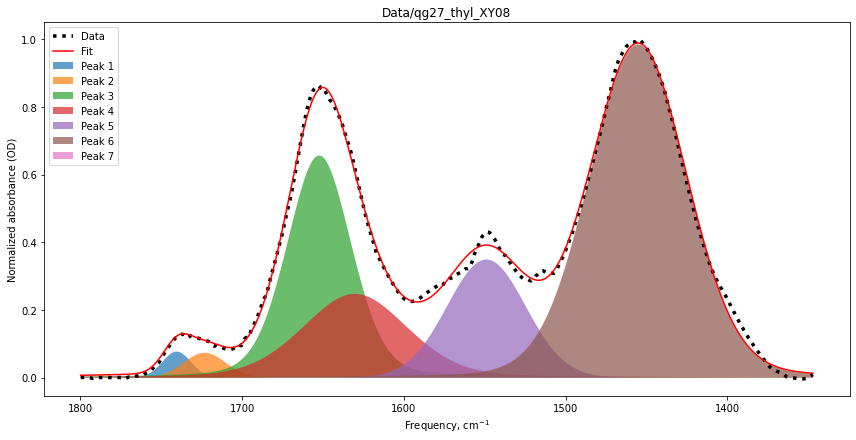

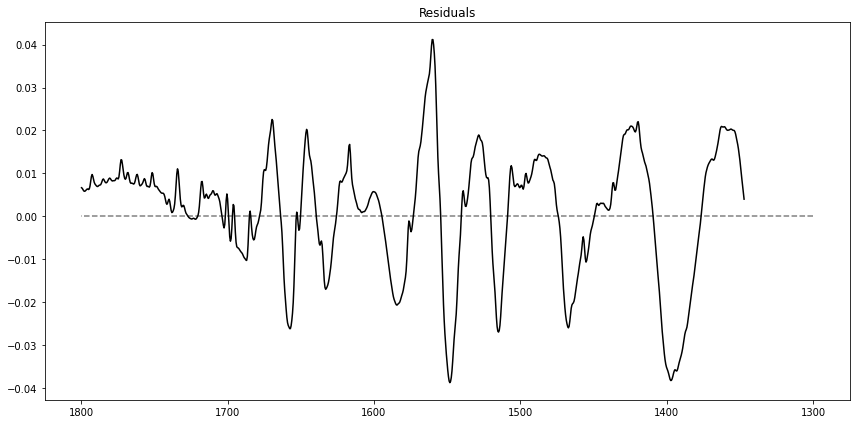

In [82]:
# Create dataframe
res_df = create_residuals_df(res_stack,y_fit_norm_intensity)
# Create Plots
ax = plot_fit(res_df,x_fit)
ax.title(filename)
plot_res(x_fit,result.residual)




In [83]:
# print(filename)
# print(lmfit.fit_report(result))


In [84]:
# Area under curve calculation
from scipy.integrate import trapezoid

a_p1 = trapezoid(peak1,x_fit)
a_p2 = trapezoid(peak2,x_fit)
print(a_p1)
print(a_p2)
sum_lipid = a_p1+a_p2
print(sum_lipid)

a_p3 = trapezoid(peak3,x_fit)
a_p4 = trapezoid(peak4,x_fit)

sum_protein = a_p3+a_p4
print(sum_protein)

r = sum_protein/sum_lipid
r

-1.6867134885843322
-2.3614753939202195
-4.048188882504552
-56.269547482270035


13.89993133113318

In [85]:
res = y_fit_norm_intensity - yout
np.savetxt("y_fit_norm_intensity.csv",y_fit_norm_intensity, delimiter=",")
np.savetxt("yout.csv",yout, delimiter=",")
np.savetxt("res.csv",res, delimiter=",")
np.savetxt("x_fit.csv",x_fit, delimiter=",")